In [19]:
# Modues to be used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import json

from re import sub
import ast 

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Global variables
MASTER_CSV_PATH = '~/Desktop/csgo-csv/'

In [2]:
## READ DATE FROM MASTER ##

# Read the data from all years
# year_vec = ['2012','2013','2014','2015','2016','2017','2018','2019']

year_vec = ['2019']

# Empty data frames
df_player = pd.DataFrame( { } )
df_team   = pd.DataFrame( { } )

df_event = pd.read_csv(MASTER_CSV_PATH+'events.csv')
df_event = df_event.set_index('id')

# Append the data from each year
for year in year_vec:
        
    file_name = MASTER_CSV_PATH + year + '-player-lvl.csv'
    df_player = df_player.append( pd.read_csv( file_name ), ignore_index=True, sort=False )
    
    file_name = MASTER_CSV_PATH + year + '-team-lvl.csv'
    df_team   = df_team.append( pd.read_csv( file_name ), ignore_index=True, sort=False )

In [4]:
# Extracting the relevant data

# Maping from a map_id to an event
map_to_event_dic = {}

for map_id in df_team.map_id.unique():
    event_id = df_team[ df_team['map_id']==map_id ]['event_id'].unique()[0]
    map_to_event_dic[map_id] = event_id

# Player's relevant stats:
# -> Dictionary that has the players relevant statistics

# Initialize the dictionary entries
player_aux_dic = {}

for player_id in df_player.player_id.unique():
    player_aux_dic[player_id]                 = {}
    player_aux_dic[player_id]['prize_money']  = float( 0.0 )
    player_aux_dic[player_id]['prize_rating'] = float( 0.0 )
    player_aux_dic[player_id]['rating']       = float( 0.0 )

    player_aux_dic[player_id]['map_count']   = 0
    player_aux_dic[player_id]['name']        = df_player[ df_player['player_id']==player_id ]['player_name'].unique()[0]

print('Dictionary initialized')

# Collect the prize money earned by each player:
# -> Here we assume that the prize is divided by 6 (players+coach) evenly
for event_id in df_team['event_id'].unique():

    try:
        # The prize distribution is a string that we convert to a dictionary
        s   = df_event.loc[event_id]['prizeDistribution']
        l   = len(s)
        dic = ast.literal_eval(s[1:l-1])
        
        # Loop through each of the places of the tournament
        for place in dic:
            try:
                prize   = float(sub(r'[^\d.]', '', place['prize']))
                team_id = place['team']['id']

                map_id_vec = df_team[ (df_team['event_id']==event_id) & (df_team['team_id']==team_id) ]['map_id'].unique()

                # Assuming the prize gets divided evenlty between players and coach 
                for player_id in df_player[ (df_player['map_id']==map_id_vec[0]) & (df_player['team_id']==team_id) ].player_id.values:
                    player_aux_dic[player_id]['prize_money'] = player_aux_dic[player_id]['prize_money'] + prize / 6.0

            except:
                continue 

    except:
        continue  
      
print('Prize money collected')

# Now we compute the global rating, including tournaments with no prize money
for map_id in df_team['map_id'].unique():

    # Get a DataFrame with the players that participated in this map
    df_tmp = df_player[ df_player['map_id']==map_id ]

    # Get a sum of all the rating for each player together with a count of the maps played
    for player_id in df_tmp['player_id'].unique():
        rating = df_tmp[ df_tmp['player_id']==player_id ]['rating'].values[0]
        player_aux_dic[player_id]['rating']    = player_aux_dic[player_id]['rating'] + rating
        player_aux_dic[player_id]['map_count'] = player_aux_dic[player_id]['map_count'] + 1

print('Rating for all players collected')

# Now we do some operations on the stats we have
for player_id in df_player.player_id.unique():
    
    # Compute the prize rating
    if player_aux_dic[player_id]['prize_money'] > 0.0:
        player_aux_dic[player_id]['prize_rating'] = np.log( player_aux_dic[player_id]['prize_money'] ) / 12.0
    else:
        player_aux_dic[player_id]['prize_rating'] = 0.0

    # Get the average rating
    if player_aux_dic[player_id]['map_count'] > 0:
        player_aux_dic[player_id]['rating'] = player_aux_dic[player_id]['rating'] / float(player_aux_dic[player_id]['map_count'])
        
print('Normalized ratings')

Dictionary initialized
Prize money collected
Rating for all players collected
Normalized ratings


## Problem with the features:
If we take the individual player features, then the order on which we put the players affect.

- We need features that take into account that all players are treated equally 

In [12]:
# For this example, we take as features:
# (1) Avg. Rating T1, Avg Rating T2
# (2) Avg. Prize_rating T1, Avg. Prize_rating T1 

# Create the feature DataFrame for training/testing
data_dic = {}

for map_id in df_team['map_id'].unique():

    data_dic[map_id] = {}

    df_tmp = df_player[ df_player['map_id']==map_id ]

    # Scores
    t1_id = df_tmp['team_id'].unique()[0]
    t2_id = df_tmp['team_id'].unique()[1]
    
    t1_score = df_team[ (df_team['team_id']==t1_id) & (df_team['map_id']==map_id) ]['team_score'].values[0]
    t2_score = df_team[ (df_team['team_id']==t2_id) & (df_team['map_id']==map_id) ]['team_score'].values[0]

    df_t1 = df_tmp[ df_tmp['team_id']==t1_id ]
    df_t2 = df_tmp[ df_tmp['team_id']==t2_id ]

    # We rank two teams in terms of their prize pool    
    rating_t1 = float(0.0)   
    prize_t1  = float(0.0) 
    count     = 0
    for ind in df_t1.index:

        player_id = df_t1.loc[ind].player_id

        count = count + 1
        
        rating_t1 = rating_t1 + player_aux_dic[player_id]['rating']
        prize_t1  = prize_t1  + player_aux_dic[player_id]['prize_rating']       

    # For the second team
    rating_t2 = float(0.0)   
    prize_t2  = float(0.0) 
    count     = 0
    for ind in df_t2.index:

        player_id = df_t2.loc[ind].player_id

        count = count + 1
        
        rating_t2 = rating_t2 + player_aux_dic[player_id]['rating']
        prize_t2  = prize_t2  + player_aux_dic[player_id]['prize_rating']       

    
    # Check if we need to change the order
    if prize_t1 > prize_t2:

        if t1_score > t2_score:
            data_dic[map_id]['fav_win'] = 1
        else:
            data_dic[map_id]['fav_win'] = 0

        data_dic[map_id]['rating_fav'] = {}
        data_dic[map_id]['rating_fav'] = rating_t1 / float(count)

        data_dic[map_id]['prize_fav'] = {}
        data_dic[map_id]['prize_fav'] = prize_t1 / float(count)

        data_dic[map_id]['rating_op'] = {}
        data_dic[map_id]['rating_op'] = rating_t2 / float(count)

        data_dic[map_id]['prize_op'] = {}
        data_dic[map_id]['prize_op'] = prize_t2 / float(count)

    else:

        if t1_score > t2_score:
            data_dic[map_id]['fav_win'] = 0
        else:
            data_dic[map_id]['fav_win'] = 1

        data_dic[map_id]['rating_fav'] = {}
        data_dic[map_id]['rating_fav'] = rating_t2 / float(count)

        data_dic[map_id]['prize_fav'] = {}
        data_dic[map_id]['prize_fav'] = prize_t2 / float(count)

        data_dic[map_id]['rating_op'] = {}
        data_dic[map_id]['rating_op'] = rating_t1 / float(count)

        data_dic[map_id]['prize_op'] = {}
        data_dic[map_id]['prize_op'] = prize_t1 / float(count)

       


data = pd.DataFrame.from_dict(data_dic,orient='index')
data.to_csv('data/training_v2.csv')

In [33]:
data[:60]
df_team.head()

map_id  map      date_unix       date_human_utc  event_id  \
0   79922  inf  1546614000000  2019-01-04 15:00:00      4273   
1   79923  mrg  1546614000000  2019-01-04 15:00:00      4273   
2   79924   d2  1546618500000  2019-01-04 16:15:00      4342   
3   79925  mrg  1546623900000  2019-01-04 17:45:00      4342   
4   79926  cch  1546630200000  2019-01-04 19:30:00      4342   

                                          event_name  team_id   team_name  \
0                 Pixel.bet Brawl: Nordic vs. Europe     8248        PACT   
1                 Pixel.bet Brawl: Nordic vs. Europe     8248        PACT   
2  ASUS ROG JTR Community Challenge Grand Finals ...     7535   ROG SPUNJ   
3  ASUS ROG JTR Community Challenge Grand Finals ...     9791  ROG pronax   
4  ASUS ROG JTR Community Challenge Grand Finals ...     8695   ROG nooky   

   team_score  team_kills  team_deaths  team_assists  
0          11        79.0         87.0          10.0  
1           9        71.0         98.0          16.0  
2           8        62.0         92.0          13.0  
3          10        72.0         97.0          10.0  
4           8        74.0         96.0          18.0

# Classification report in the Logistic Model

The function 'classification_report' from sklearn produces a string output that incudes:
- Precision: Ratio tp/(tp+fp) where tp is the number of true positives and fp is the number of false possitives.
    - Intuitively: Ability of the classifier not to label as positive a sample that is negative.
- Recall: Ratio tp/(tp+fn) where tp is the number of true positives and fn is the number of false negatives. 
    - Intuitively: Ability of the classifier to find all the positive samples
- F1-score: Balanced F-score or F-measure 2*(precision*recall)/(precision+recall)
    - Intuitively: Weighted average of the precision and recall. The closer to 1 the better


Documentation: 
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support

In [32]:
# Divide data set into training and testing sets
# -> We use 75% of the data for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(data.drop('fav_win',axis=1),data['fav_win'], test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=500)

X_train

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

confusion_matrix(y_test.values, predictions)


>               precision    recall  f1-score   support

Underdog wins       0.55      0.10      0.18      1238
Favorite wins       0.69      0.96      0.81      2624

     accuracy                           0.69      3862
    macro avg       0.62      0.53      0.49      3862
 weighted avg       0.65      0.69      0.60      3862



array([[ 129, 1109],
       [ 105, 2519]])

In [30]:
print( logmodel.coef_ )
print( logmodel.classes_ )
print( logmodel.intercept_ )


[[ 6.79351745 -7.35064437]]
[0 1]
[1.03107959]


array([[  87, 1237],
       [  77, 2461]])

In [29]:
# Test to see if the money rating helps or not
# -> Let's drop the money
data_no_money = data.drop(['prize_fav','prize_op'],axis=1)

# data_no_money.head()

# Divide data set into training and testing sets
# -> We use 75% of the data for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(data_no_money.drop('fav_win',axis=1),data_no_money['fav_win'], test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=500)

X_train

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

print( logmodel.coef_ )
print( logmodel.classes_ )
print( logmodel.intercept_ )

confusion_matrix(y_test.values, predictions)


>               precision    recall  f1-score   support

Underdog wins       0.53      0.07      0.12      1324
Favorite wins       0.67      0.97      0.79      2538

     accuracy                           0.66      3862
    macro avg       0.60      0.52      0.45      3862
 weighted avg       0.62      0.66      0.56      3862

[[ 6.79351745 -7.35064437]]
[0 1]
[1.03107959]


array([[  87, 1237],
       [  77, 2461]])

In [ ]:
# Check if model works just with team avg rating

In [40]:
#print(player_aux_dic)
#print(prize)

df_money = pd.DataFrame.from_dict(player_aux_dic,orient='index',)
df_money = df_money.sort_values(['prize_money','rating'],ascending=False)

df_money[:60]


prize_money  prize_rating    rating  map_count         name
7592   359750.000000      1.066097  1.266101        159       device
9032   359750.000000      1.066097  1.199623        159       Magisk
7398   359750.000000      1.066097  1.155220        159      dupreeh
4954   359750.000000      1.066097  1.153648        159        Xyp9x
7412   359750.000000      1.066097  1.101195        159       gla1ve
8797   232041.666667      1.029556  1.106953        233     Stewie2K
8738   231541.666667      1.029376  1.242018        223        EliGE
8520   231541.666667      1.029376  1.213964        222          NAF
10394  231541.666667      1.029376  1.172511        223      Twistzz
7687   231541.666667      1.029376  1.076968        221        nitr0
9960   149085.833333      0.992690  1.191884        276       frozen
11893  148514.166667      0.992370  1.347934        271        ZywOo
7322   148514.166667      0.992370  1.065646        271         apEX
8184   148514.166667      0.992370  1.034354        271         ALEX
7169   148514.166667      0.992370  1.026494        271          RpK
429    146333.333333      0.991137  0.983211        218     karrigan
11816  145500.000000      0.990661  1.215700        200         ropz
2730   145500.000000      0.990661  1.059851        202       chrisJ
10671  145000.000000      0.990374  1.165913        230        Ethan
11219  145000.000000      0.990374  1.157293        229         CeRq
8574   139208.333333      0.986977  1.190050        201        woxic
8523   138541.666667      0.986577  1.060968        217        tarik
9136   138333.333333      0.986452  1.208578        225       Brehze
11916  117590.166667      0.972913  1.142743        175       sergej
695    117590.166667      0.972913  1.133103        174         allu
4076   117590.166667      0.972913  1.070632        174       Aerial
7248   117590.166667      0.972913  1.008391        174       xseveN
8507   114625.000000      0.970785  1.019175        206    stanislaw
11343  113344.500000      0.969849  1.129137        278        SHiPZ
1225   105882.500000      0.964174  1.099452        219         shox
334    103347.000000      0.962154  0.970691        217        AdreN
7834   100333.333333      0.959688  1.000000        233       v1c7oR
2799    99583.333333      0.959063  0.986494        251       bubble
8183    98333.333333      0.958010  1.087600        175         rain
885     98333.333333      0.958010  1.043543        175  olofmeister
12126   97833.333333      0.957585  1.191195        251       poizon
3741    97500.000000      0.957301  1.172294        170         NiKo
10697   97355.833333      0.957177  1.054906        212      blocker
7168    96347.500000      0.956310  1.092687        227         NBK-
9816    95006.833333      0.955142  1.023286        140      Aleksib
7167    91799.166667      0.952280  1.174960        252       kennyS
284     91799.166667      0.952280  1.087729        251        JaCkz
13666   90791.666667      0.951360  1.136019        206      Brollan
7528    90791.666667      0.951360  1.117398        196        KRIMZ
3849    90791.666667      0.951360  1.083073        205           JW
7998    89000.000000      0.949699  1.316383        141       s1mple
8918    89000.000000      0.949699  1.231583        139   electronic
7594    89000.000000      0.949699  1.075180        139       flamie
13776   84805.333333      0.945676  1.284477        306         Jame
13239   84805.333333      0.945676  1.145738        305       qikert
11942   84805.333333      0.945676  1.112492        305       buster
2757    80416.666667      0.941248  1.029739        153     GuardiaN
12553   78396.333333      0.939128  1.202632        285       yuurih
15631   77771.333333      0.938461  1.209649        285     KSCERATO
12521   77771.333333      0.938461  1.111544        285          arT
12822   77563.000000      0.938237  1.045901        283         VINI
9616    73674.166667      0.933951  1.063048        210       AmaNEk
8564   

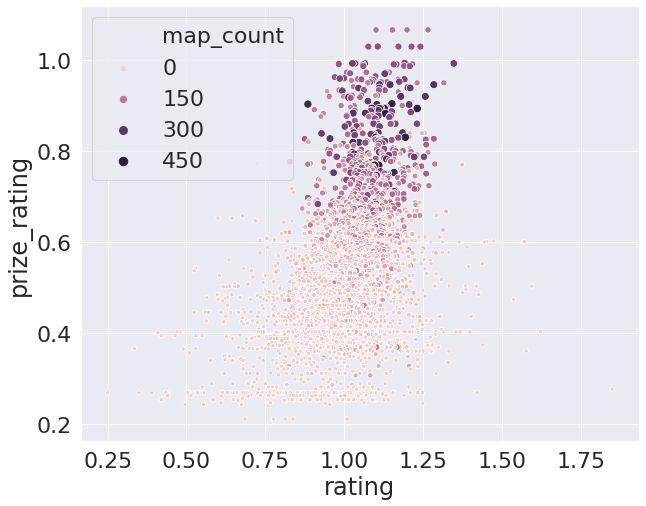

In [41]:
sns.set_style("whitegrid")
sns.set(font_scale=2)

df_tmp = df_money[ df_money['prize_money']>np.log(3000) /12]
plt.figure(figsize=(10,8));

sns.scatterplot(data=df_tmp,x='rating',y='prize_rating',size='map_count',hue='map_count');

In [60]:
#X = pd.DataFrame.as_matrix(df_tmp,columns=['rating','prize_money'])
X = pd.DataFrame.as_matrix(df_tmp,columns=['prize_rating'])
#X = df_tmp.values(columns=['rating','prize_money'])
#X = df_tmp.values(columns=['prize_rating'])
#
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
#df_tmp.sort_values('rating',ascending=False)[:30]

#Z = df_tmp.index.values

df_tmp['label'] = kmeans.labels_

/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [65]:
df_tmp[:60]
df_tmp[(df_tmp['label']==2) | (df_tmp['label']==1)].sort_values(['prize_money','rating'],ascending=False)[:60]

prize_money  prize_rating    rating  map_count         name  label
7592   359750.000000      1.066097  1.266101        159       device      1
9032   359750.000000      1.066097  1.199623        159       Magisk      1
7398   359750.000000      1.066097  1.155220        159      dupreeh      1
4954   359750.000000      1.066097  1.153648        159        Xyp9x      1
7412   359750.000000      1.066097  1.101195        159       gla1ve      1
8797   232041.666667      1.029556  1.106953        233     Stewie2K      1
8738   231541.666667      1.029376  1.242018        223        EliGE      1
8520   231541.666667      1.029376  1.213964        222          NAF      1
10394  231541.666667      1.029376  1.172511        223      Twistzz      1
7687   231541.666667      1.029376  1.076968        221        nitr0      1
9960   149085.833333      0.992690  1.191884        276       frozen      1
11893  148514.166667      0.992370  1.347934        271        ZywOo      1
7322   148514.166667      0.992370  1.065646        271         apEX      1
8184   148514.166667      0.992370  1.034354        271         ALEX      1
7169   148514.166667      0.992370  1.026494        271          RpK      1
429    146333.333333      0.991137  0.983211        218     karrigan      1
11816  145500.000000      0.990661  1.215700        200         ropz      1
2730   145500.000000      0.990661  1.059851        202       chrisJ      1
10671  145000.000000      0.990374  1.165913        230        Ethan      1
11219  145000.000000      0.990374  1.157293        229         CeRq      1
8574   139208.333333      0.986977  1.190050        201        woxic      1
8523   138541.666667      0.986577  1.060968        217        tarik      1
9136   138333.333333      0.986452  1.208578        225       Brehze      1
11916  117590.166667      0.972913  1.142743        175       sergej      1
695    117590.166667      0.972913  1.133103        174         allu      1
4076   117590.166667      0.972913  1.070632        174       Aerial      1
7248   117590.166667      0.972913  1.008391        174       xseveN      1
8507   114625.000000      0.970785  1.019175        206    stanislaw      1
11343  113344.500000      0.969849  1.129137        278        SHiPZ      1
1225   105882.500000      0.964174  1.099452        219         shox      1
334    103347.000000      0.962154  0.970691        217        AdreN      1
7834   100333.333333      0.959688  1.000000        233       v1c7oR      1
2799    99583.333333      0.959063  0.986494        251       bubble      1
8183    98333.333333      0.958010  1.087600        175         rain      1
885     98333.333333      0.958010  1.043543        175  olofmeister      1
12126   97833.333333      0.957585  1.191195        251       poizon      1
3741    97500.000000      0.957301  1.172294        170         NiKo      1
10697   97355.833333      0.957177  1.054906        212      blocker      1
7168    96347.500000      0.956310  1.092687        227         NBK-      1
9816    95006.833333      0.955142  1.023286        140      Aleksib      1
7167    91799.166667      0.952280  1.174960        252       kennyS      1
284     91799.166667      0.952280  1.087729        251        JaCkz      1
13666   90791.666667      0.951360  1.136019        206      Brollan      1
7528    90791.666667      0.951360  1.117398        196        KRIMZ      1
3849    90791.666667      0.951360  1.083073        205           JW      1
7998    89000.000000      0.949699  1.316383        141       s1mple      1
8918    89000.000000      0.949699  1.231583        139   electronic      1
7594    89000.000000      0.949699  1.075180        139       flamie      1
13776   84805.333333      0.945676  1.284477        306         Jame      1
13239   84805.333333      0.945676  1.145738        305       qikert      1
11942   84805.333333      0.945676  1.112492        305       buster      1
2757    80416.666667      0.941248  1.029739        153  

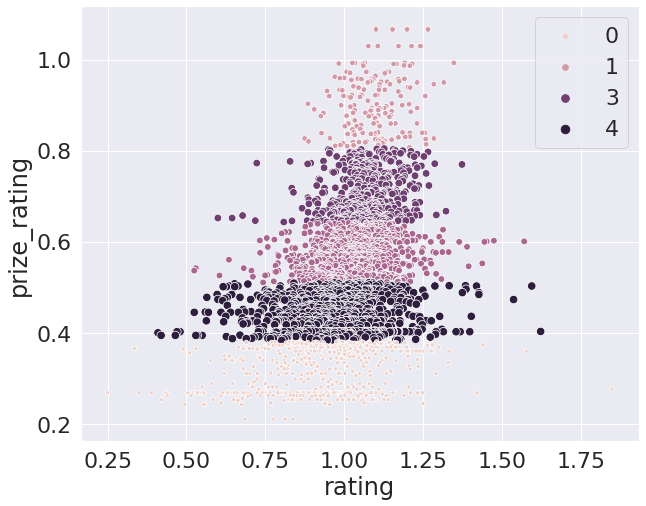

In [61]:
plt.figure(figsize=(10,8));
sns.scatterplot(data=df_tmp,x='rating',y='prize_rating',hue=kmeans.labels_,size=kmeans.labels_);
#sns.scatterplot(df_tmp,x='rating',y='prize_money');